### Çok Değişkenli Aykırı Değer Analizi: Local Outlier Factor

###### Çok değişkenli aykırı değer nedir?

* Diyelim ki elimizde iki tane değişken var değişkenin birincisi yaş değişkeni, ikincisi ise evlilik sayısı değişkeni olsun. Evlilik sayısı değişkenine odaklanacak olursak 3 kere evlenmek olmak aykırı bir değer midir diye düşünüldüğünde olmayabilir. Ancak sayı yükseldikçe aykırı değer olma ihtimali artacaktır. Şimdi de yaş değişkenini ele alalım. Yaş değişkenimiz 17 olsun. 17 sayısı da yaş için anormal bir değer değil gibi gözüküyor. Ama şimdi soru şudur: 17 yaşında olup 3 defa evlenmiş olma durumu anormal midir? Evet anormaldir. Kısaca tek başına aykırı olamayacak değerler birlikte ele alındığında bu durum aykırılık yaratıyor olabilir. Bundan dolayı aykırı değişkenlere çok değişkenli olarak bakmak da faydalı olacaktır.

###### Local Outlier Factor (LOF) Yöntemi Nedir?

* LOF yöntemi çok değişkenli bir aykırı değer belirleme yöntemidir. İki görsel üzerinden bu durumu inceleyelim:

###### Görsel 1:
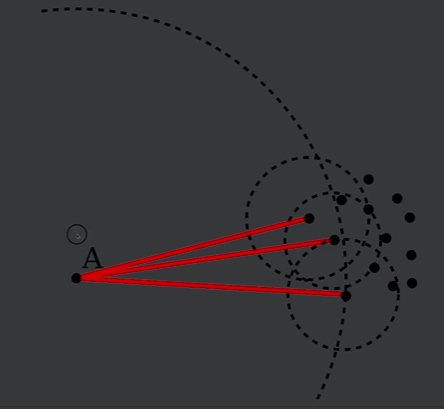

* LOF yöntemi gözlemleri bulundukları konumda yoğunluk tabanlı skorlayarak buna göre aykırı değer olabilecek değerleri tanıma imkanı sağlar. Bir noktanın local yoğunluğu demek ilgili noktanın etrafındaki komşuluklar demektir. Eğer bir nokta komşuluklarının yoğunluğundan anlamlı bir şekilde düşük ise bu durumda bu nokta daha seyrek bir bölgededir. Demek ki bu aykırı değer olabilir yorumu yapılır. 

* Yukarıdaki resimdeki küçük dairelere bakıldığında etrafındaki komşuluklar yoğun diyebiliriz. Ancak A noktasının komşuluklarına baktığımızda komşuluğunun seyrek olduğunu söyleyebiliriz. Anlaşılacağı üzere buradaki nokta komşuluklarının local yoğunluklarından oldukça farklıdır. A noktası komşularının yoğunluğundan anlamlı şekilde farklı ve düşüktür. Bundan dolayı A noktasına aykırı değer muamelesi yapılır.

###### Görsel 2:
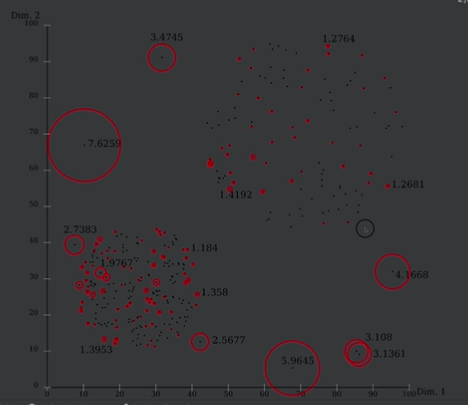

* LOF yöntemi der ki ben size bir skor vereceğim, bu benden aldığınız skor 1'e ne kadar yakın olursa o kadar iyidir der. Dolayısıyla 1'den uzaklaştıkça ilgili gözlem gördüğümüz gibi artık nokta değil gözlemin tamamını değerlendiriyoruz. 1'den uzaklaştıkça ilgili gözlemin outlier olma ihtimali artar. Küçük noktalar inlier'lardır. Skor değeri büyüdükçe (1'den uzaklaştıkça) bu artık bu değerlerin outlier olabileceğine yönelik fikir verir. Dolayısıyla buradaki büyük noktalar outlier noktalarıdır. Peki burada biz müdahale edebiliyor muyuz? Evet edebiliyoruz. Mesela bu senaryo için threshold eşik değerini yani skor değerini 5 olarak belirlersek sadece 2 tane aykırı değerimiz olacaktır. Bunu yukarıdaki görselden görebiliriz. Dolayısıyla LOF yöntemi bize bir threshold olarak da müdahale etme imkanı sağlar.

* Çok değişkenli dedik ancak yukarıda sanki 2 değişken var. Hayır yoktur.
* DİİKAT: Elimizde iki değişken olduğunda bu şekilde iki boyutta görselleştirebiliriz. Ya 100 değişken varsa iki boyutta nasıl görselleştirme yapabiliriz? Bunu bir mülakat sorusu olarak düşünebiliriz. Eğer elimizdeki 100 değişkeni o 100 değişkenin taşıdığı bilginin büyük bir miktarını taşıdığı varsayabileceğimiz iki boyuta indirgeyebilirsek bu durumda yapabiliriz. Bunu da PCA (Temel Bileşen Analizi) Yöntemi ile yapabiliriz. Güzel bir mülakat sorusudur.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [3]:
df = sns.load_dataset("diamonds")

# Sadece sayısal değişkenleri seçerek:
df = df.select_dtypes(include = ['float64', 'int64'])

# Eksik değerleri drop ederek:
df = df.dropna()

# veri setimizi getiriyoruz.
df.head()

,carat,depth,table,price,x,y,z
0,0.230,61.500,55.000,326,3.950,3.980,2.430
1,0.210,59.800,61.000,326,3.890,3.840,2.310
2,0.230,56.900,65.000,327,4.050,4.070,2.310
3,0.290,62.400,58.000,334,4.200,4.230,2.630
4,0.310,63.300,58.000,335,4.340,4.350,2.750


In [6]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [7]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 53940
Variables: 7
cat_cols: 0
num_cols: 7
cat_but_car: 0
num_but_cat: 0


In [8]:
# Bu dataframe'de aykırı değer var mı bakalım:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


for col in num_cols:
    print(col, check_outlier(df, col))

carat True
depth True
table True
price True
x True
y True
z True


In [10]:
# carat değişkenini seçip kaç tane outlier vardır soruna cevap arıyor olsak:
low, up = outlier_thresholds(df, "carat")
df[((df["carat"] < low) | (df["carat"] > up))].shape

(1889, 7)

In [11]:
# Başka bir değişken seçelim:
low, up = outlier_thresholds(df, "depth")

df[((df["depth"] < low) | (df["depth"] > up))].shape

(2545, 7)

* DİKKAT: Başta tanımladığımız outlier_thresholders fonksiyonu 25'e 75'likti. Ancak Vahit Hoca ben bunu 5'e 95 kullanırım demişti. Peki neden? Şimdi LOF yöntemine gittiğimizdeki aykırı değer sayısına odaklanalım, bir de tek tek değişkenlerde baktığımıza odaklanalım. Eğer konuya tek değişkenli yaklaşıp 25'e 75'lik silseydik ciddi bir veri kaybı olacaktı ya da doldursaydık tortu yaratacaktık. Bunun sonucunda kendi kendimize veri setine gürültü ekleyecektik. Durduk yere problem oluşturmuş olacaktık. Ağaç yöntemleri kullanıyorsak bu sebeple hiç dokunmamayı tercih etmeliyiz ya da Vahit Hoca'nın yaklaşımını kullanara çok ucundan traşlamayı tercih ederek ekstra ekstra aykırı olanları traşlama yaklaşımına yönelmeliyiz. Burada da bunun ne kadar ciddi bir problem olduğunu ve gözden kaçmaması gereken bir konu olduğunu ispat etmeye çalışalım. Neyi aklımızda tutmalıyız? Tek başına baktığımızda çok yüksek sayıda aykırılıklar geldi. Bir de buna çok değişkenli yaklaştığımızda ne olacak bir bakalım:

In [12]:
# Daha önce yukarıda import etmiş olduğumuz LocalOutlierFactor metodunu getiriyoruz.
clf = LocalOutlierFactor(n_neighbors=20)

* n_neighbors komşuluk sayısını ifade ediyor. Buradaki komşuluk sayısı değişebilir. 5, 3 yapabiliriz. Ama buradaki problem denemeler sonucunda elde ettiğimiz komşuluk sayılarının hangisinin daha olacağını yorumlayamıyor olacak olmamızdır. Dolayısıyla burada LocalOutlierFactor metodunun ön tanımlı değeri olan 20'yi kullanmak tercih edilmelidir.

In [13]:
# Veri setimize uygulayalım.
clf.fit_predict(df)

array([-1, -1, -1, ...,  1,  1,  1])

In [ ]:
# Takip edilebilirlik açısından df_scores diyerek tutalım:
df_scores = clf.negative_outlier_factor_

In [15]:
# 5 tanesini gözlemleyelim:
df_scores[0:5]

array([-1.58352526, -1.59732899, -1.62278873, -1.33002541, -1.30712521])

* DİKKAT: Bunlar LocalOutlierFactor skorları fakat burada kullanılan metod bize bunları eksi değerlerle verdi dolayısıyla eksi değerlere göre bunları değerlendiriyor olacağız. Bunları eksi değerlere göre değerlendirmek istemiyorsak aşağıdaki işlemi yaparsak skorlar pozitife dönecektir.

In [16]:
df_scores = -df_scores

In [17]:
df_scores[0:5]

array([1.58352526, 1.59732899, 1.62278873, 1.33002541, 1.30712521])

* DİKKAT: Bunu fonksiyonun bize verdiği orjinal(negatif değerlerle) haliyle kullanmayı tercih edeceğiz. Eşik değere karar vermek için kullanıcı olarak bir bakış gerçekleştirmek istediğimizde oluşturacak olduğumuz elbow yöntemi yani destek yöntemi grafik tekniğinde daha rahat okunabilirlik açısından eksi olarak bırakacağız.

In [18]:
df_scores = clf.negative_outlier_factor_
df_scores[0:5]

array([-1.58352526, -1.59732899, -1.62278873, -1.33002541, -1.30712521])

* DİKKAT: Buradaki değerlerin 1'e yakın olması inlier olduklarını gösteriyor demiştik. Artık -1'e yakın olması inlier olma durumunu gösteriyor gibi değerlendireceğiz. Diyelim ki -1 ve -10 arası değerlere sahibiz. -10 gidildikçe değerimizin daha aykırı olduğunu söyleyebiliriz.

In [20]:
# Değerleri küçükten büyüğe sıralayalım:
np.sort(df_scores)[0:5]

array([-8.60430658, -8.20889984, -5.86084355, -4.98415175, -4.81502092])